In [67]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential


from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package punkt to /Users/Cyrille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Cyrille/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Cyrille/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Read data

In [68]:
train_df = pd.read_csv('../../data/imdb_train_data_small.csv')
test_df = pd.read_csv('../../data/imdb_test_data_small.csv')

In [69]:
test_df

,text,label
0,This movie has bad writing and bad editing. It...,0
1,I'm still laughing- Not! I'm still asking my m...,0
2,While I'm normally a big fan of John Turturro'...,0
3,<br /><br />The author tried to make a Kevin S...,0
4,Oh boy ! It was just a dream ! What a great id...,0
...,...,...
295,My wife and I struggle to find movies like thi...,1
296,"While watching this film recently, I constantl...",1
297,Trust the excellent and accurate Junagadh75 re...,1
298,Valley Girl is an exceptionally well made film...,1


In [70]:
train_df

,text,label
0,I rated this a 3. The dubbing was as bad as I ...,0
1,"<br /><br />Cheap-looking and ugly, this film ...",0
2,This film concerns purportedly non-establishme...,0
3,Ho-hum. An inventor's(Horst Buchholz)deadly bi...,0
4,"Definitely not worth the rental, but if you ca...",0
...,...,...
695,This has to be the funniest stand up comedy I ...,1
696,. . . is just as good as the original. Very ne...,1
697,"A quite good film version of the novel, though...",1
698,Maybe the greatest film ever about jazz.<br />...,1


In [71]:
train_df["label"].unique()

array([0, 1])

# Tokenization

Create your own tokenization algorithm. Remember to handle upper/lower case, comma, punctioation and so on.
Each word should hava an integer connected to it. Word as key and integer as value in a dict is one way to do it.

Tensorflow have tokenization models, but try to bild it yourself.

In [72]:
import re
def tokenize(dataset: pd.DataFrame):

    text = dataset["text"]
    text = text.str.lower()
    text = text.str.replace(r'[^a-z0-9\s]', '', regex=True)
    
    words_series = text.str.split()
    
    token_map = {"<UNK>": 0}
    reverse_token_map = {0: "<UNK>"}
    next_token = 1
    
    for word_list in words_series:
        for word in word_list:
            if word not in token_map:
                token_map[word] = next_token
                reverse_token_map[next_token] = word
                next_token += 1
    
    return token_map, reverse_token_map

In [73]:
token_map, reverse_token_map = tokenize(train_df)

In [74]:
token_map

{'<UNK>': 0,
 'i': 1,
 'rated': 2,
 'this': 3,
 'a': 4,
 '3': 5,
 'the': 6,
 'dubbing': 7,
 'was': 8,
 'as': 9,
 'bad': 10,
 'have': 11,
 'seen': 12,
 'plot': 13,
 'yuck': 14,
 'im': 15,
 'not': 16,
 'sure': 17,
 'which': 18,
 'ruined': 19,
 'movie': 20,
 'more': 21,
 'jet': 22,
 'li': 23,
 'is': 24,
 'definitely': 25,
 'great': 26,
 'martial': 27,
 'artist': 28,
 'but': 29,
 'ill': 30,
 'stick': 31,
 'to': 32,
 'jackie': 33,
 'chan': 34,
 'movies': 35,
 'until': 36,
 'somebody': 37,
 'tells': 38,
 'me': 39,
 'jets': 40,
 'english': 41,
 'up': 42,
 'par': 43,
 'br': 44,
 'cheaplooking': 45,
 'and': 46,
 'ugly': 47,
 'film': 48,
 'didnt': 49,
 'even': 50,
 'seem': 51,
 'entertain': 52,
 'kids': 53,
 'in': 54,
 'audience': 55,
 'except': 56,
 'for': 57,
 'one': 58,
 'fairly': 59,
 'amusing': 60,
 'toilet': 61,
 'joke': 62,
 'christopher': 63,
 'lloyd': 64,
 'way': 65,
 'past': 66,
 'his': 67,
 'prime': 68,
 'actually': 69,
 'quite': 70,
 'tiresome': 71,
 'role': 72,
 'although': 73,
 'so

# Remove stopwords

In [75]:
stop_words = set(stopwords.words('english'))

In [76]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [77]:
def remove_stopwords(text):
    words = text.split()
    fltered_words = [word for word in words if word not in stop_words]
    filtered_text = ' '.join(fltered_words)
    return filtered_text

In [78]:
example_text = "This is a sample sentence, showing off the stop words filtration."
remove_stopwords(example_text)

'This sample sentence, showing stop words filtration.'

# Lemmatization

In [79]:
lemmatizer = WordNetLemmatizer()

In [80]:
lemmatizer.lemmatize("house"), lemmatizer.lemmatize("houses"), lemmatizer.lemmatize("housing"), lemmatizer.lemmatize("housed")

('house', 'house', 'housing', 'housed')

In [81]:
def lemmatize(word):
    # lemmatize word without using lemmatizer 
    lemmatizer = WordNetLemmatizer()
    word = lemmatizer.lemmatize(word, pos='v')
    return word

# Word embedding and sentiment analysis model
We want to create a model that can say if a movie review is bad or good.

- Preprocess the text
- Convert text to seqiuence of integers
- Create architecture that includes embeddings
- Build and train your models
- Evaluate preformance

Building models from scratch is not something you usually do, but those who would like to dig deeper into the math behind Simple RNN, LSTM and GRU can do it by creating the cells from scratch.

In [82]:
train_df.head()

,text,label
0,I rated this a 3. The dubbing was as bad as I ...,0
1,"<br /><br />Cheap-looking and ugly, this film ...",0
2,This film concerns purportedly non-establishme...,0
3,Ho-hum. An inventor's(Horst Buchholz)deadly bi...,0
4,"Definitely not worth the rental, but if you ca...",0


In [83]:
test_df.head()

,text,label
0,This movie has bad writing and bad editing. It...,0
1,I'm still laughing- Not! I'm still asking my m...,0
2,While I'm normally a big fan of John Turturro'...,0
3,<br /><br />The author tried to make a Kevin S...,0
4,Oh boy ! It was just a dream ! What a great id...,0


In [84]:
# create a function that takes a dataframe and cleans text column to lowercased, 

def lower_case_text_column(df: pd.DataFrame):
    df["text"] = df["text"].str.lower()
    return df

In [85]:
def remove_punctuation(df: pd.DataFrame):
    df["text"] = df["text"].str.replace(r'[^a-z0-9\s]', '', regex=True)
    return df

In [86]:
def remove_stopwords_from_df(df: pd.DataFrame):
    df["text"] = df["text"].apply(remove_stopwords)
    return df

In [87]:
def remove_emojis(df: pd.DataFrame):
    df["text"] = df["text"].str.replace(r'[^\w\s]+', '', regex=True)
    return df

In [88]:
train_lower = lower_case_text_column(train_df)
test_lower = lower_case_text_column(test_df)
train_lower.head(), test_lower.head()

(                                                text  label
 0  i rated this a 3. the dubbing was as bad as i ...      0
 1  <br /><br />cheap-looking and ugly, this film ...      0
 2  this film concerns purportedly non-establishme...      0
 3  ho-hum. an inventor's(horst buchholz)deadly bi...      0
 4  definitely not worth the rental, but if you ca...      0,
                                                 text  label
 0  this movie has bad writing and bad editing. it...      0
 1  i'm still laughing- not! i'm still asking my m...      0
 2  while i'm normally a big fan of john turturro'...      0
 3  <br /><br />the author tried to make a kevin s...      0
 4  oh boy ! it was just a dream ! what a great id...      0)

In [89]:
train_no_punc = remove_punctuation(train_lower)
test_no_punc = remove_punctuation(test_lower)
train_no_punc.head(), test_no_punc.head()

(                                                text  label
 0  i rated this a 3 the dubbing was as bad as i h...      0
 1  br br cheaplooking and ugly this film didnt ev...      0
 2  this film concerns purportedly nonestablishmen...      0
 3  hohum an inventorshorst buchholzdeadly biologi...      0
 4  definitely not worth the rental but if you cat...      0,
                                                 text  label
 0  this movie has bad writing and bad editing it ...      0
 1  im still laughing not im still asking my mysel...      0
 2  while im normally a big fan of john turturros ...      0
 3  br br the author tried to make a kevin smiths ...      0
 4  oh boy  it was just a dream  what a great idea...      0)

In [90]:
train_no_stop = remove_stopwords_from_df(train_no_punc)
test_no_stop = remove_stopwords_from_df(test_no_punc)
train_no_stop.head(), test_no_stop.head()

(                                                text  label
 0  rated 3 dubbing bad seen plot yuck im sure rui...      0
 1  br br cheaplooking ugly film didnt even seem e...      0
 2  film concerns purportedly nonestablishment typ...      0
 3  hohum inventorshorst buchholzdeadly biological...      0
 4  definitely worth rental catch cable youll plea...      0,
                                                 text  label
 0  movie bad writing bad editing difficult follow...      0
 1  im still laughing im still asking point barely...      0
 2  im normally big fan john turturros work actor ...      0
 3  br br author tried make kevin smiths style mov...      0
 4  oh boy dream great idea mr lynch lucky people ...      0)

In [91]:
train_no_emojis = remove_emojis(train_no_stop)
test_no_emojis = remove_emojis(test_no_stop)
train_no_emojis.head(), test_no_emojis.head()

(                                                text  label
 0  rated 3 dubbing bad seen plot yuck im sure rui...      0
 1  br br cheaplooking ugly film didnt even seem e...      0
 2  film concerns purportedly nonestablishment typ...      0
 3  hohum inventorshorst buchholzdeadly biological...      0
 4  definitely worth rental catch cable youll plea...      0,
                                                 text  label
 0  movie bad writing bad editing difficult follow...      0
 1  im still laughing im still asking point barely...      0
 2  im normally big fan john turturros work actor ...      0
 3  br br author tried make kevin smiths style mov...      0
 4  oh boy dream great idea mr lynch lucky people ...      0)

In [92]:
def remove_br_tags(df: pd.DataFrame):
    df["text"] = df["text"].str.replace(r'<br />', '', regex=True)
    return df

In [93]:
trainn = remove_br_tags(train_no_emojis)
testt = remove_br_tags(test_no_emojis)
trainn.head(), testt.head()

(                                                text  label
 0  rated 3 dubbing bad seen plot yuck im sure rui...      0
 1  br br cheaplooking ugly film didnt even seem e...      0
 2  film concerns purportedly nonestablishment typ...      0
 3  hohum inventorshorst buchholzdeadly biological...      0
 4  definitely worth rental catch cable youll plea...      0,
                                                 text  label
 0  movie bad writing bad editing difficult follow...      0
 1  im still laughing im still asking point barely...      0
 2  im normally big fan john turturros work actor ...      0
 3  br br author tried make kevin smiths style mov...      0
 4  oh boy dream great idea mr lynch lucky people ...      0)

In [94]:
def remove_whitespace(df: pd.DataFrame):
    df["text"] = df["text"].str.strip()
    return df

In [95]:
train1 = remove_whitespace(trainn)
test1 = remove_whitespace(testt)
train1.head(), test1.head()

(                                                text  label
 0  rated 3 dubbing bad seen plot yuck im sure rui...      0
 1  br br cheaplooking ugly film didnt even seem e...      0
 2  film concerns purportedly nonestablishment typ...      0
 3  hohum inventorshorst buchholzdeadly biological...      0
 4  definitely worth rental catch cable youll plea...      0,
                                                 text  label
 0  movie bad writing bad editing difficult follow...      0
 1  im still laughing im still asking point barely...      0
 2  im normally big fan john turturros work actor ...      0
 3  br br author tried make kevin smiths style mov...      0
 4  oh boy dream great idea mr lynch lucky people ...      0)

In [96]:
def remove_numbers(df: pd.DataFrame):
    df["text"] = df["text"].str.replace(r'\d+', '', regex=True)
    return df

In [97]:
train_final = remove_numbers(train1)
test_final = remove_numbers(test1)
train_final.head(), test_final.head()

(                                                text  label
 0  rated  dubbing bad seen plot yuck im sure ruin...      0
 1  br br cheaplooking ugly film didnt even seem e...      0
 2  film concerns purportedly nonestablishment typ...      0
 3  hohum inventorshorst buchholzdeadly biological...      0
 4  definitely worth rental catch cable youll plea...      0,
                                                 text  label
 0  movie bad writing bad editing difficult follow...      0
 1  im still laughing im still asking point barely...      0
 2  im normally big fan john turturros work actor ...      0
 3  br br author tried make kevin smiths style mov...      0
 4  oh boy dream great idea mr lynch lucky people ...      0)

In [98]:
def lemmatize_text(df: pd.DataFrame):
    df["text"] = df["text"].apply(lemmatize)
    return df

In [99]:
train_final1 = lemmatize_text(train_final)
test_final1 = lemmatize_text(test_final)
train_final1.head(), test_final1.head()


(                                                text  label
 0  rated  dubbing bad seen plot yuck im sure ruin...      0
 1  br br cheaplooking ugly film didnt even seem e...      0
 2  film concerns purportedly nonestablishment typ...      0
 3  hohum inventorshorst buchholzdeadly biological...      0
 4  definitely worth rental catch cable youll plea...      0,
                                                 text  label
 0  movie bad writing bad editing difficult follow...      0
 1  im still laughing im still asking point barely...      0
 2  im normally big fan john turturros work actor ...      0
 3  br br author tried make kevin smiths style mov...      0
 4  oh boy dream great idea mr lynch lucky people ...      0)

In [100]:
# split final using train_test_split from sklearn
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_final1["text"], train_final1["label"], test_size=0.15, random_state=42)
x_train.shape, x_val.shape, y_val.shape, y_val.shape

((595,), (105,), (105,), (105,))

In [101]:
x_val, y_val

(158    please avoid movie costs without doubt worst m...
 500    kenneth branagh shows excellent skill acting w...
 396    brilliant movie drawings amazing bad ended beg...
 155     visit lodz ghetto nazioccupied poland recorde...
 321    far absolute worst movie seen last  years saw ...
                              ...                        
 470    second part animatrix collection animated shor...
 164    well saybr br seen film still wonder hell poin...
 641    movie compared sting caperheistcon game films ...
 323    finished watching tv say worst film ever seen ...
 65     spoiler included would saybr br film possible ...
 Name: text, Length: 105, dtype: object,
 158    0
 500    1
 396    1
 155    0
 321    0
       ..
 470    1
 164    0
 641    1
 323    0
 65     0
 Name: label, Length: 105, dtype: int64)

In [102]:
x_test, y_test = test_final1["text"], test_final1["label"]
x_test.shape, y_test.shape

((300,), (300,))

In [103]:
token_map, reverse_token_map = tokenize(train_final1)

In [104]:
x_train

409    br br human body wowbr br  sunrises human life...
49     unbleepingbelievable meg ryan doesnt even look...
118    awful absolutely awful plot point end looks li...
192    film justly famous one horrible examples propa...
39     hell dmovie bad acting bad special effects wor...
                             ...                        
71     movie tells tender tale demented scientist fia...
106    standard view purely awful movie however rates...
270    movie goodin fact worst elvis movie seenit lit...
435    say action allegorical tale everything basical...
102    killer tomatoes movies special kind humor eith...
Name: text, Length: 595, dtype: object

In [105]:
def sentence_to_token(sentence, token_map):
    return [token_map[word] if word in token_map else 0 for word in sentence.split()]

x_train_tokens = [sentence_to_token(sentence, token_map) for sentence in x_train]
x_val_tokens = [sentence_to_token(sentence, token_map) for sentence in x_val]
x_test_tokens = [sentence_to_token(sentence, token_map) for sentence in x_test]

In [106]:
def max_length(df: pd.DataFrame):
    max_length = df["text"].str.split().str.len().max()
    return max_length

max_length(train_final1)

67

In [107]:
max_length = train_final1['text'].apply(lambda x: len(x.split())).max()
max_length

67

In [108]:
max_length_test = test_final1['text'].apply(lambda x: len(x.split())).max()
max_length_test

66

In [109]:
def pad_tokens(tokens, max_length):
    return tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen=max_length, padding='post', truncating='post')

In [110]:
x_train_padded = pad_tokens(x_train_tokens, max_length)
x_val_padded = pad_tokens(x_val_tokens, max_length)
x_test_padded = pad_tokens(x_test_tokens, max_length)

In [133]:
def build_model(token_map):
    model = Sequential()
    model.add(Embedding(input_dim=len(token_map), output_dim=32, mask_zero=True))
    model.add(Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation="relu", kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [127]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [134]:
model = build_model(token_map=token_map) 
history = model.fit(x_train_padded, y_train, epochs=50, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stopping])

Epoch 1/50
19/19 [==============================] - 13s 205ms/step - loss: 1.8212 - accuracy: 0.4941 - val_loss: 1.6544 - val_accuracy: 0.5619
Epoch 2/50
19/19 [==============================] - 1s 36ms/step - loss: 1.5330 - accuracy: 0.5798 - val_loss: 1.4057 - val_accuracy: 0.5714
Epoch 3/50
19/19 [==============================] - 1s 38ms/step - loss: 1.3109 - accuracy: 0.6235 - val_loss: 1.2175 - val_accuracy: 0.6095
Epoch 4/50
19/19 [==============================] - 1s 38ms/step - loss: 1.1321 - accuracy: 0.7008 - val_loss: 1.0668 - val_accuracy: 0.6381
Epoch 5/50
19/19 [==============================] - 1s 39ms/step - loss: 0.7996 - accuracy: 0.8958 - val_loss: 0.9062 - val_accuracy: 0.7143
Epoch 6/50
19/19 [==============================] - 1s 42ms/step - loss: 0.4468 - accuracy: 0.9580 - val_loss: 1.1560 - val_accuracy: 0.6857
Epoch 7/50
19/19 [==============================] - 1s 39ms/step - loss: 0.3130 - accuracy: 0.9697 - val_loss: 1.1858 - val_accuracy: 0.6952
Epoch 8/50


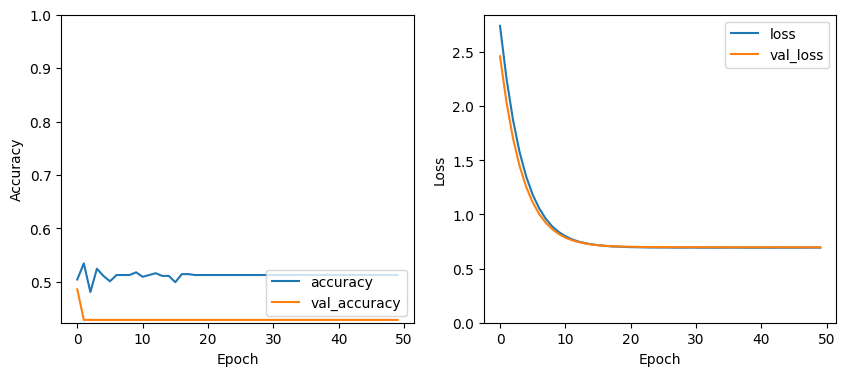

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([None, 1])
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, None])
plt.legend(loc='upper right')
plt.show()


In [121]:
model.evaluate(x_test_padded, y_test)

10/10 [==============================] - 0s 11ms/step - loss: 1.1947 - accuracy: 0.7067


[1.1947458982467651, 0.7066666483879089]

In [ ]:
preds = model.predict(x_test_padded)

10/10 [==============================] - 3s 11ms/step


In [ ]:
predicted_labels = [1 if pred > 0.5 else 0 for pred in preds]

In [ ]:
predicted_labels[:10]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0]

In [ ]:
y_test[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: label, dtype: int64

In [ ]:
def tokens_to_sentence(tokens, reverse_token_map):
    words = [reverse_token_map[token] for token in tokens if token != 0]
    return " ".join(words)

In [ ]:
for i in range(len(x_test_padded[:10])):
    print(tokens_to_sentence(x_test_padded[i], reverse_token_map))
    print("Predicted sentiment: ", predicted_labels[i])
    print("Actual sentiment: ", y_test[i])
    print("\n")

movie bad writing bad editing difficult follow going nothing characters makes much sense major every seconds result none action sequences interesting movie two hours worth away scenes merely fact share common actors movie doesnt even enough sense humor good bad movie
Predicted sentiment:  0
Actual sentiment:  0


im still laughing im still asking point barely got movie sucks tries charming touching turns stupid recommend
Predicted sentiment:  0
Actual sentiment:  0


im normally big fan john work actor director great disappointment although film charming moments overall falls flat worst film confusing movie set italy italian new york bother making historical film fails convey setting want see wellmade historical film also theater go see tim robbins rock movie many including fine performance john turturro
Predicted sentiment:  1
Actual sentiment:  0


br br author tried make kevin style movie definitely failed result boring film cannot sustain dialogues fortunately control could see tap

In [ ]:
def pad_data(embedded_text):
    # All sentences should be of the same lenght, but if a sentence is shorter than the longest, pad it.
    return padded_text

## RNN with tensorflow modules
[Simple RNN cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN)

[Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

In [ ]:
def build_rnn_model():
    return model

## RNN from scratch

In [ ]:
class RNNCell(tf.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.Wxh =
        self.Whh =
        self.bh =

    def __call__(self, x, h):
        h_next = 
        return h_next

SyntaxError: invalid syntax (177378052.py, line 4)

In [ ]:
# RNN Model Class
class MyRNNModel(tf.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=1, sequence_length=100):
        super().__init__()
        self.embedding =
        self.rnn_cell = RNNCell(embedding_dim, hidden_dim)
        self.Why = 
        self.by = 

    def __call__(self, x):
        x = 
        h = 

        # Process the input sequence
        for t in range(sequence_length):
            x_t = x[:, t, :]
            h = self.rnn_cell(x_t, h)

        y = 
        return tf.sigmoid(y)

In [ ]:
def train_step(model, inputs, targets):
    clip_norm = 1.0
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_function(targets, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(model.trainable_variables)
    return loss

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((padded_train_data, y)).batch(batch_size)
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0
    total_batches = 0

    for batch_inputs, batch_targets in train_dataset:
        loss = train_step(model, batch_inputs, batch_targets)
        epoch_loss += loss.numpy()

        # Calculate accuracy
        predictions = model(batch_inputs)
        accuracy = calculate_accuracy(batch_targets, predictions)
        epoch_accuracy += accuracy.numpy()

        total_batches += 1

    avg_loss = epoch_loss / total_batches
    avg_accuracy = epoch_accuracy / total_batches
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

## LSTM

[LSTM Cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell)

In [ ]:
def build_lstm_model():
    return model

## LSTM from scrtch

In [ ]:
# LSTM Cell Class
class LSTMCell(tf.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Gates: input, forget, cell, output
        self.Wi =
        self.Wf =
        self.Wc =
        self.Wo =
        self.bi =
        self.bf =
        self.bc =
        self.bo =

    def __call__(self, x, h, c):
        combined = tf.concat([x, h], 1)

        i = 
        f = 
        o = 
        c_ = 

        c_new = 
        h_new =

        return h_new, c_new

In [ ]:
# LSTM Model Class
class MyLSTMModel(tf.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding =
        self.lstm_cell = LSTMCell(embedding_dim, hidden_dim)
        self.Why =
        self.by =

    def __call__(self, x):
        x =
        h =
        c =

        for t in range(sequence_length):
            x_t = x[:, t, :]
            h, c = self.lstm_cell(x_t, h, c)

        y =
        return tf.sigmoid(y)

In [ ]:
def train_step(model, inputs, targets):
    clip_norm = 1.0
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_function(targets, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    clipped_gradients = [tf.clip_by_norm(g, clip_norm) for g in gradients]
    optimizer.apply_gradients(model.trainable_variables)
    return loss

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((padded_train_data, y)).batch(batch_size)
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0
    total_batches = 0

    for batch_inputs, batch_targets in train_dataset:
        loss = train_step(model, batch_inputs, batch_targets)
        epoch_loss += loss.numpy()

        # Calculate accuracy
        predictions = model(batch_inputs)
        accuracy = calculate_accuracy(batch_targets, predictions)
        epoch_accuracy += accuracy.numpy()

        total_batches += 1

    avg_loss = epoch_loss / total_batches
    avg_accuracy = epoch_accuracy / total_batches
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

## GRU
[GRU Cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell)

In [ ]:
def build_gru_model():
    return model

## GRU from scratch

In [ ]:
# GRU Cell Class
class GRUCell(tf.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Update gate parameters
        self.Wz =
        self.bz =

        # Reset gate parameters
        self.Wr =
        self.br =

        # Candidate hidden state parameters
        self.Wh =
        self.bh =
        
    def __call__(self, x, h):
        combined = tf.concat([x, h], 1)

        # Update gate
        z =

        # Reset gate
        r =

        # Candidate hidden state
        combined_reset =
        h_candidate =

        # New hidden state
        h_new =

        return h_new

In [ ]:
# GRU Model Class
class MyGRUModel(tf.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding =
        self.gru_cell =
        self.Why =
        self.by =

    def __call__(self, x):
        x =
        h =

        for t in range(sequence_length):
            x_t = x[:, t, :]
            h = self.gru_cell(x_t, h)

        y =
        return tf.sigmoid(y)

In [ ]:
def train_step(model, inputs, targets):
    clip_norm = 1.0
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_function(targets, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(model.trainable_variables)
    return loss

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((padded_train_data, y)).batch(batch_size)
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0
    total_batches = 0

    for batch_inputs, batch_targets in train_dataset:
        loss = train_step(model, batch_inputs, batch_targets)
        epoch_loss += loss.numpy()

        # Calculate accuracy
        predictions = model(batch_inputs)
        accuracy = calculate_accuracy(batch_targets, predictions)
        epoch_accuracy += accuracy.numpy()

        total_batches += 1

    avg_loss = epoch_loss / total_batches
    avg_accuracy = epoch_accuracy / total_batches
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')